In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#Get the stock quote 
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#Take a look at the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,29.500000,27.650000,28.940001,28.080000,928100,28.080000
2012-01-04,28.670000,27.500000,28.209999,27.709999,630100,27.709999
2012-01-05,27.930000,26.850000,27.760000,27.120001,1005500,27.120001
2012-01-06,27.790001,26.410000,27.200001,26.910000,986300,26.910000
2012-01-09,27.490000,26.120001,27.000000,27.250000,897000,27.250000
...,...,...,...,...,...,...
2019-12-24,425.470001,412.690002,418.359985,425.250000,8054700,425.250000
2019-12-26,433.480011,426.350006,427.910004,430.940002,10633900,430.940002
2019-12-27,435.309998,426.109985,435.000000,430.380005,9945700,430.380005


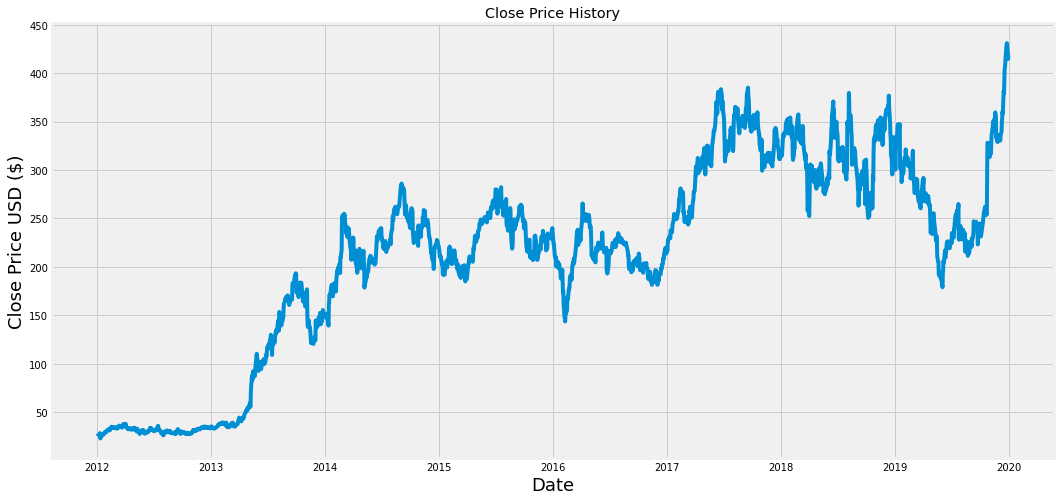

In [3]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [0]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [0]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [0]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [0]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
#Train the model
model.fit(x_train, y_train, batch_size=50, epochs=10)

Epoch 1/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.7721e-04
Epoch 2/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.4240e-04
Epoch 3/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.2994e-04
Epoch 4/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.3226e-04
Epoch 5/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.1793e-04
Epoch 6/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.2163e-04
Epoch 7/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.1407e-04
Epoch 8/10
1550/1550 [==============================] - 6s 4ms/step - loss: 5.0537e-04
Epoch 9/10
1550/1550 [==============================] - 7s 4ms/step - loss: 4.9657e-04
Epoch 10/10
1550/1550 [==============================] - 6s 4ms/step - loss: 4.8930e-04


In [0]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


#Convert x_test to a numpy array 
x_test = np.array(x_test)



#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [0]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [17]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

15.3968202630236

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


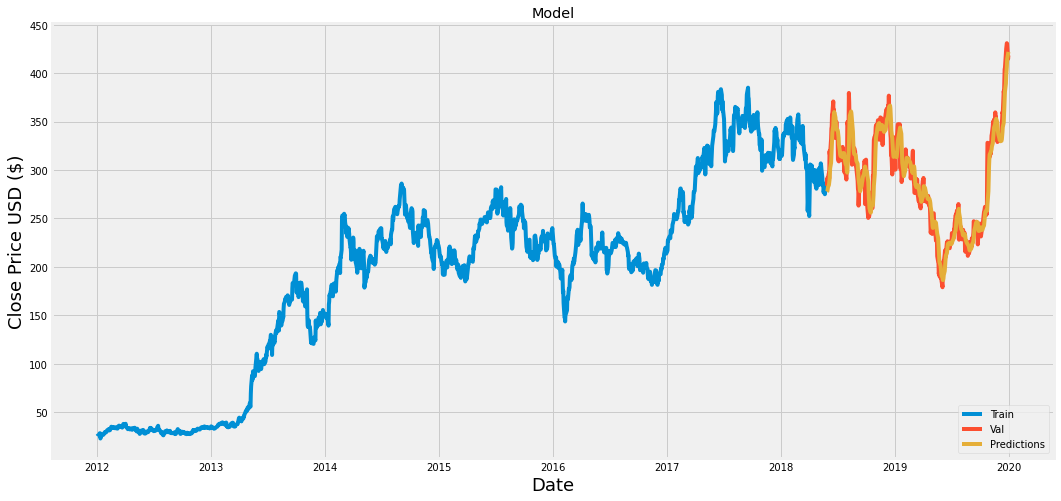

In [18]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
